# Scenario 1
- Inputs: Simulator, 
- Query: Will Intervention keep hospitalizations below 3000?
- Intervention 1: Dec 1 - Mar 1, 5% decrease in transmission
- Intervention 2: Jan 1 - Mar 1, X% decrease required?

# Open Issues
1. Infected > Hospitalized, how is Hospitalized defined?
    - Assume that H = I * HR, HR = hospitalization rate, maybe synthesize HR
2. Initial Conditions?  
    - From Data.  

# Goals
1. Synthesize (X, Start Intervention)
2. Synthesize (HR, gamma, End of Intervention)
3. Models: CHIME, BUCKY, CHIME SVIIR

# Analysis:
1. Intervention 1 works (yes/no), Intervention 2 (range of X that works, single variable synthesis)
2. Compute a metric: I1: sum of differences with threshold, I2: uniform grid evaluation of sum of differences.
3. Additional Parameters: HR, Start of Intervention, 
4. Sensitivity Analysis: What values of infection rate will the intervention work or not.  

# Operations:
- evaluate point
- project onto subset of dimensions
- project after assigning dimensions 
- Evaluate metric over remaining space

In [1]:
from model2smtlib.bilayer.translate import BilayerEncoder, BilayerEncodingOptions
from funman.scenario.consistency import ConsistencyScenario
from funman.scenario.parameter_synthesis import ParameterSynthesisScenario
from funman import Funman
from funman.model import Parameter, QueryLE, QueryTrue
from funman.model.bilayer import Bilayer, BilayerMeasurement, BilayerModel
from funman_demo.handlers import ResultCacheWriter, RealtimeResultPlotter, NotebookImageRefresher
from funman.search_utils import ResultCombinedHandler, SearchConfig
from funman.search_episode import DRealSearchEpisode
from funman.search import SMTCheck, BoxSearch
import os
import tempfile
# import funman_dreal # Needed to use dreal with pysmt

%load_ext autoreload
%autoreload 2

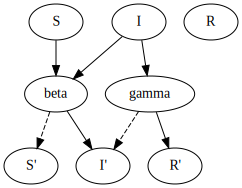

In [4]:
# Define the dynamics with a bilayer

chime_bilayer_src = {
    "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
    "Win": [
        {"arg": 1, "call": 1},
        {"arg": 2, "call": 1},
        {"arg": 2, "call": 2},
    ],
    "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
    "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
    "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
    "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
}

chime_bilayer = Bilayer.from_json(chime_bilayer_src)

# Define the measurements made of the bilayer variables
# Hospitalizations (H) are a proportion (hr) of those infected (I)

measurements = {
    "state" : [{"variable": "I"}],
    "observable" : [{"observable" : "H"}],
    "rate" : [{"parameter": "hr"}],
    "Din": [{"variable": 1, "parameter": 1}],
    "Dout": [{"parameter": 1, "observable": 1}]
}
hospital_measurements = BilayerMeasurement.from_json(measurements)

# Model Setup for both Intervention 1
# - Prescribed reduction in transmission, i.e., beta' = (1-transmission_reduction)beta

transmission_reduction = 0.00
duration = 120 #days
model = BilayerModel(
    chime_bilayer,
    measurements = hospital_measurements,
    init_values={"S": 10000, "I": 1, "R": 1},
    parameter_bounds={
        "beta": [0.000067*(1.0-transmission_reduction), 0.000067*(1.0-transmission_reduction)],
        # "beta" : [0.00005, 0.00007],
        "gamma": [1.0/14.0, 1.0/14.0],
        "hr": [0.01, 0.01]
    },
)

#query = QueryTrue()
query = QueryLE("I", 1000)

chime_bilayer.to_dot()

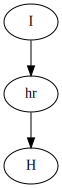

In [ ]:
hospital_measurements.to_dot()

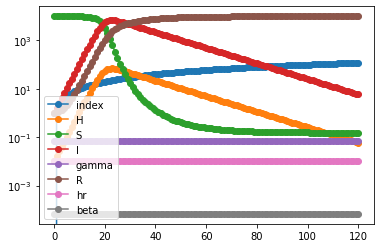

In [13]:
# Analyze Intervention 1 to check it will achieve goals of query

# tmp_dir_path = tempfile.mkdtemp(prefix="funman-")
result = Funman().solve(
    ConsistencyScenario(
        model,
        query,
        smt_encoder=BilayerEncoder(config=BilayerEncodingOptions(step_size=1, max_steps=120)) # four months,
    ),
    config=SearchConfig(solver="dreal", search=SMTCheck)
)
if result.consistent:
    result.plot(logy=True)
    # print(f"parameters = {result.parameters()}")
    result.dataframe()
else:
    print("Scenario Inconsistent")

In [15]:
result.dataframe()

,index,H,S,I,gamma,R,hr,beta
0,0,0.010000,10000.000000,1.000000,0.071429,1.000000,0.01,0.000067
1,1,0.015986,9999.330000,1.598571,0.071429,1.071429,0.01,0.000067
2,2,0.025554,9998.259029,2.555359,0.071429,1.185612,0.01,0.000067
3,3,0.040846,9996.547237,4.084626,0.071429,1.368138,0.01,0.000067
4,4,0.065286,9993.811482,6.528621,0.071429,1.659897,0.01,0.000067
...,...,...,...,...,...,...,...,...
116,116,0.078614,0.153372,7.861384,0.071429,9993.985153,0.01,0.000067
117,117,0.072999,0.153292,7.299931,0.071429,9994.546681,0.01,0.000067
118,118,0.067786,0.153217,6.778575,0.071429,9995.068104,0.01,0.000067
119,119,0.062945,0.153147,6.294454,0.071429,9995.552288,0.01,0.000067


In [7]:
# Intervention 2 is over a shorter time period, with different initial conditions
# The task is to find the level of efficacy beta needed to satisfy the query

model.parameter_bounds["beta"] = [0.0, 0.001] # beta no longer prescribed

# The efficacy can be up to 4x that of baseline (i.e., 0.05 - 0.20)
parameters = [
    Parameter("beta", lb=0.0, ub=0.001)
]
tmp_dir_path = tempfile.mkdtemp(prefix="funman-")
result = Funman().solve(
    ParameterSynthesisScenario(
        parameters,
        model,
        query,
        smt_encoder=BilayerEncoder(config=BilayerEncodingOptions(step_size=1, max_steps=10 #duration-30
        ))
    ),
    config=SearchConfig(
        number_of_processes=1,
        tolerance=1e-6,
        solver="dreal",
        search=BoxSearch,
        # wait_action = NotebookImageRefresher(os.path.join(tmp_dir_path, "search.png"), sleep_for=1),
        handler=ResultCombinedHandler(
            [
                ResultCacheWriter(os.path.join(tmp_dir_path, "search.json")),
                RealtimeResultPlotter(
                    parameters,
                    plot_points=True,
                    realtime_save_path=os.path.join(tmp_dir_path, "search.png"),
                ),
            ]
        ),
    ),
)
result.plot()

<!-- (:process infection
 :parameters (?gamma)
 :precondition (and)
 :effect (and 
            (increase (I) (function1))
            (increase (R) (function2))
            (increase (S) (function3))
            )
 )

 (:durative-action mandate
  :parameters ()
  :duraiton (?duration)
  :precondition (and)
  :effect (and (at-start (increase (beta) (function1))
                (at-end (decrease (beta) (function1))))
  )

  (:event infected-threshold
   :precondtion (>= I 1000)
   :effect (fail)
   ) -->

In [14]:
result

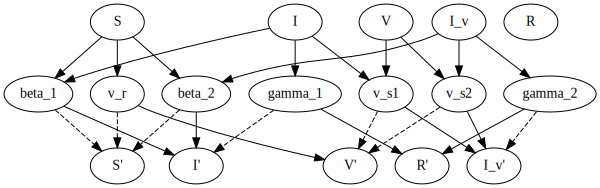

In [ ]:
sviir = {"Qin":[{"variable":"S"},
        {"variable":"V"},
        {"variable":"I"},
        {"variable":"I_v"},
        {"variable":"R"}],
 "Box":[{"parameter":"beta_1"},
        {"parameter":"beta_2"},
        {"parameter":"v_r"},
        {"parameter":"v_s1"},
        {"parameter":"v_s2"},
        {"parameter":"gamma_1"},
        {"parameter":"gamma_2"}],
 "Qout":[{"tanvar":"S'"},
         {"tanvar":"V'"},
         {"tanvar":"I'"},
         {"tanvar":"I_v'"},
         {"tanvar":"R'"}],
 "Win":[{"arg":1,"call":1},
        {"arg":1,"call":2},
        {"arg":1,"call":3},
        {"arg":2,"call":4},
        {"arg":2,"call":5},
        {"arg":3,"call":1},
        {"arg":3,"call":4},
        {"arg":3,"call":6},
        {"arg":4,"call":2},
        {"arg":4,"call":5},
        {"arg":4,"call":7}],
 "Wa":[{"influx":1,"infusion":3},
       {"influx":2,"infusion":3},
       {"influx":3,"infusion":2},
       {"influx":4,"infusion":4},
       {"influx":5,"infusion":4},
       {"influx":6,"infusion":5},
       {"influx":7,"infusion":5}],
 "Wn":[{"efflux":1,"effusion":1},
       {"efflux":2,"effusion":1},
       {"efflux":3,"effusion":1},
       {"efflux":4,"effusion":2},
       {"efflux":5,"effusion":2},
       {"efflux":6,"effusion":3},
       {"efflux":7,"effusion":4}]}
       
Bilayer.from_json(sviir).to_dot()

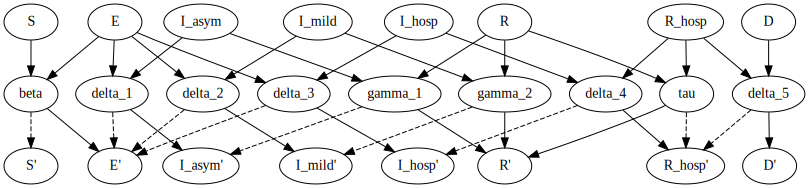

In [ ]:
bucky = {"Qin":[{"variable":"S"},
        {"variable":"E"},
        {"variable":"I_asym"},
        {"variable":"I_mild"},
        {"variable":"I_hosp"},
        {"variable":"R"},
        {"variable":"R_hosp"},
        {"variable":"D"}],
 "Box":[{"parameter":"beta"},
        {"parameter":"delta_1"},
        {"parameter":"delta_2"},
        {"parameter":"delta_3"},
        {"parameter":"gamma_1"},
        {"parameter":"gamma_2"},
        {"parameter":"delta_4"},
        {"parameter":"tau"},
        {"parameter":"delta_5"}],
 "Qout":[{"tanvar":"S'"},
         {"tanvar":"E'"},
         {"tanvar":"I_asym'"},
         {"tanvar":"I_mild'"},
         {"tanvar":"I_hosp'"},
         {"tanvar":"R'"},
         {"tanvar":"R_hosp'"},
         {"tanvar":"D'"}],
 "Win":[{"arg":1,"call":1},
        {"arg":2,"call":1},
        {"arg":2,"call":2},
        {"arg":2,"call":3},
        {"arg":2,"call":4},
        {"arg":3,"call":2},
        {"arg":3,"call":5},
        {"arg":4,"call":3},
        {"arg":4,"call":6},
        {"arg":5,"call":4},
        {"arg":5,"call":7},
        {"arg":6,"call":5},
        {"arg":6,"call":6},
        {"arg":6,"call":8},
        {"arg":7,"call":7},
        {"arg":7,"call":8},
        {"arg":7,"call":9},
        {"arg":8,"call":9}],
 "Wa":[{"influx":1,"infusion":2},
       {"influx":2,"infusion":3},
       {"influx":3,"infusion":4},
       {"influx":4,"infusion":5},
       {"influx":5,"infusion":6},
       {"influx":6,"infusion":6},
       {"influx":7,"infusion":7},
       {"influx":8,"infusion":6},
       {"influx":9,"infusion":8}],
 "Wn":[{"efflux":1,"effusion":1},
       {"efflux":2,"effusion":2},
       {"efflux":3,"effusion":2},
       {"efflux":4,"effusion":2},
       {"efflux":5,"effusion":3},
       {"efflux":6,"effusion":4},
       {"efflux":7,"effusion":5},
       {"efflux":8,"effusion":7},
       {"efflux":9,"effusion":7}]}
       
Bilayer.from_json(bucky).to_dot()       


In [ ]:
# Analysis of results
# Intervention 1 result and explanation
# Intervention 2 range of parameter and metric computed on range ?
# Compute metric over parameter space from points in parameter space

# Scneario 2
- Inputs:
    - Query: Rate of vaccination to keep cases under threshold over period of time
    - Result: Compute minimum vacc rate
- Parameters:
    - Vaccination rate
    - Age range (optional)
    - Age specific efficacy

# Scenario 3
- Identify indifference region wrt. parameters.
- Outside of indifference region are candidate parameters where one model is better.
- Generate two parameter spaces, identify symm diff, and evaluate metric over symm diff uniform grid.  Metric can be the fit to data.

In [ ]:
# Notes in this cell

# chime_bilayer_src = {
#     "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
#     "Win": [
#         {"arg": 1, "call": 1},
#         {"arg": 2, "call": 1},
#         {"arg": 2, "call": 2},
#     ],
#     "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
#     "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
#     "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
#     "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
# }

# measurements = {
#     "S" : [{"variable": "I"}],
#     "O" : [{"observable" : "H"}],
#     "D" : [{"parameter": "hr"}],
#     "Din": [{"variable": 1, "parameter": 1}],
#     "Dout": [{"parameter": 1, "observable": 1}]
# }

# chime_bilayer = Bilayer.from_json(chime_bilayer_src, measurements)


# chime_bilayer_src2 = {
#     "Wa": [{"influx": 1, "infusion": 2}, {"influx": 2, "infusion": 3}],
#     "Win": [
#         {"arg": 1, "call": 1},
#         {"arg": 2, "call": 1},
#         {"arg": 2, "call": 2},
#     ],
#     "Box": [{"parameter": "beta"}, {"parameter": "gamma"}],
#     "Qin": [{"variable": "S"}, {"variable": "I"}, {"variable": "R"}],
#     "Qout": [{"tanvar": "S'"}, {"tanvar": "I'"}, {"tanvar": "R'"}],
#     "Wn": [{"efflux": 1, "effusion": 1}, {"efflux": 2, "effusion": 2}],
# }

# measurements2 = {
#     "S" : [{"variable": "I"}],
#     "O" : [{"observable" : "H"}],
#     "D" : [{"parameter": "hr"}],
#     "Din": [{"variable": 1, "parameter": 1}],
#     "Dout": [{"parameter": 1, "observable": 1}]
# }
# chime_bilayer2 = Bilayer.from_json(chime_bilayer_src2, measurements2)

# fail = Bilayer.from_json({}, {})
# HybridAutomaton(
#     [Node(chime_bilayer, QueryLE(chime_bilayer, "I", 1000)), Node(chime_bilayer2, QueryLE(chime_bilayer, "I", 1000)), Node(fail, None)],
#     [Jump(chime_bilayer, Guard(QueryLE(chime_bilayer, "days", 10)),chime_bilayer2)]
#     )

# chime_bilayer = Bilayer.from_json(chime_bilayer_src, measurements)
# chime_bilayer.to_dot()
